# Libraries

In [ ]:
pip install PyYAML==3.12

In [ ]:
import keras

In [ ]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

In [1]:
%matplotlib inline
import pandas as pd
import _pickle as pickle
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

print("TensorFlow version: ", tf.__version__)
import os
import sys 
import pickle as pk
import  pickle
from datetime import datetime
import pandas as pd
import requests
import urllib.request
import time
from bs4 import BeautifulSoup
#import nctoolkit as ncµ
import netCDF4 as nc4
import threading
import datetime as dt  # Python standard library datetime  module
import xarray as xr
import xbatcher as xb

import imageio
os.environ['PROJ_LIB'] = '/opt/python3-anaconda50-5.0.1-7ipsl.el6/share/proj'


from sklearn.metrics import silhouette_samples, silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from skimage.measure import block_reduce
from keras import callbacks as cbks



TensorFlow version:  2.2.0


In [2]:
import tensorflow.keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, MaxPooling2D, MaxPooling3D, Dropout, BatchNormalization, Flatten, Conv2D, Conv3D, AveragePooling3D, LSTM, Reshape
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import History 

In [3]:
#reload support file 
import sys
import os
py_file_location = "/home/dbennour/DeepPV/"
sys.path.append(os.path.abspath(py_file_location))
import read_cloudalbedo_files, cloud_index_functions, write_cloud_index_files
import PV_Generator
py_file_location = "/home/dbennour/DeepPV/Unet_models/"
sys.path.append(os.path.abspath(py_file_location))
import UNet_model
from read_cloudalbedo_files import *
from PV_Generator import PV_DataGenerator
from UNet_model import *
import importlib
importlib.reload(read_cloudalbedo_files)
importlib.reload(PV_Generator)
importlib.reload(UNet_model)
# type(AECNN_model)
# importlib.reload(write_cloud_index_files)

<module 'UNet_model' from '/home/dbennour/DeepPV/Unet_models/UNet_model.py'>

# Load AECNN

In [11]:
path='/home/dbennour/DeepPV/AECNN_Model/'
aecnn=loadModel("AECNN_v4_2",path)

Yaml Model  AECNN_v4_2 .yaml loaded 
Weights  AECNN_v4_2 .h5 loaded 


# Model 2: CMV prediction

In [4]:
# data_path='/homedata/dbennour/DeepPV/CAL_CMV_slot/'
# data_path='/bdd/pegase/DEEPPV/CAL_CMV_slot/'
data_path='/net/nfs/ssd2/dbennour/CAL_CMV_slot/'
data_generator_train = PV_DataGenerator('train_data', data_path,to_fit=True,batch_size=16)
data_generator_val=PV_DataGenerator('val_data', data_path,to_fit=True,batch_size=16)


In [11]:
data_path='/net/nfs/ssd2/dbennour/CAL_CMV_slot/'
data_generator_test=PV_DataGenerator('test_data', data_path,to_fit=True,batch_size=16)

In [5]:
test_name=sorted(os.listdir('/net/nfs/ssd2/dbennour/CAL_CMV_slot/test_data/'))


In [93]:
# train_seq1=[i for i in test_name if i.startswith('CAL_CMV_20201006')]
# train_seq2=[i for i in test_name if i.startswith('CAL_CMV_20201007')]
# train_seq3=[i for i in test_name if i.startswith('CAL_CMV_20201008')]
# 


In [7]:
train_seq=[i for i in test_name if (i.startswith('CAL_CMV_20201006') or i.startswith('CAL_CMV_20201007') or i.startswith('CAL_CMV_20201008'))]
train_start_index=test_name.index(train_seq1[0])
train_end_index=test_name.index(train_seq3[-1])
X_train, Y_train,cmv_train=generate_data(train_start_index,train_end_index,'train_data')

In [8]:
val_seq=[i for i in test_name if i.startswith('CAL_CMV_20201009')]
val_start_index=test_name.index(val_seq[0])
val_end_index=test_name.index(val_seq[-1])
X_val,Y_val,cmv_val=generate_data(val_start_index,val_end_index,'val_data')

In [6]:
test_seq=[i for i in test_name if i.startswith('CAL_CMV_20201010')]
test_start_index=test_name.index(test_seq[0])
test_end_index=test_name.index(test_seq[-1])
X_test,Y_test,cmv_test=generate_data(test_start_index,test_end_index,'test_data')

In [94]:
# X_test,Y_test,cmv_test=generate_data(7124,7130,'test_data')


In [13]:
X_train.shape

(111, 513, 513, 3, 1)

In [12]:
cmv_test.shape

(38, 513, 513, 2)

## U-Net

In [ ]:
n_filters = 10
dropout = 0.2
batchnorm = True
    input_img = Input((513, 513, 3,1))
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 4, batchnorm = batchnorm)
    p1 =  MaxPooling3D((3, 3,3), padding = 'same')(c1)
    p1 = Dropout(dropout)(p1)


    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 4, batchnorm = batchnorm)
    p2 = MaxPooling3D((3, 3,3), padding = 'same')(c2)
    p2 = Dropout(dropout)(p2)

    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 4, batchnorm = batchnorm)
    p3 = MaxPooling3D((3, 3,3), padding = 'same')(c3)
    p3 = Dropout(dropout)(p3)

    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 4, batchnorm = batchnorm)
    p4 = MaxPooling3D((3, 3,1), padding = 'same')(c4)
    p4 = Dropout(dropout)(p4)

    c5 = conv2d_block(p4, n_filters = n_filters * 8, kernel_size = 4, batchnorm = batchnorm)

    #     Expansive Path
    u6 = Conv3DTranspose(n_filters * 8, (4, 4,4), strides = (3, 3,1), padding = 'same')(c5)
    u6=Cropping3D(cropping=((2, 0), (2, 0),(0,0)), data_format=None)(u6)

    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 4, batchnorm = batchnorm)

    u7 = Conv3DTranspose(n_filters * 4, (4, 4,4), strides = (3, 3,1), padding = 'same')(c6)
    # u7=Cropping3D(cropping=((2, 0), (2, 0),(0,0)), data_format=None)(u7)

    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 4, batchnorm = batchnorm)

    u8 = Conv3DTranspose(n_filters * 2, (4, 4,4), strides = (3, 3,1), padding = 'same')(c7)
    # u8=Cropping3D(cropping=((2, 0), (2, 0),(0,0)), data_format=None)(u8)

    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 4, batchnorm = batchnorm)

    u9 = Conv3DTranspose(n_filters * 1, (4, 4,4), strides = (3, 3,3), padding = 'same')(c8)
    # u9=Cropping3D(cropping=((2, 0), (2, 0),(0,0)), data_format=None)(u9)

    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 4, batchnorm = batchnorm)
    c10 = conv2d_block(c9, n_filters * 1, kernel_size = 4, batchnorm = batchnorm)
    # c11 = Conv3D(2, (1, 1,2), padding='same')(c10)
    # c11 = Conv3D(2, (1, 1,2), padding='same')(c11)
    c11 = Conv3D(1, (1, 1,2))(c10)
    c11=(LeakyReLU(alpha=0.1))(c11)
    # c11=Conv3D(2, (1, 1,2))(c11)

    c12 = Dense(32)(c11)
    #     c11=Dense(10)(c10)
    outputs = Conv3D(1, (1, 1,1), activation='tanh',kernel_regularizer=l2(0.02))(c12)
    # outputs = Conv3D(1, (1, 1,1), activation='sigmoid',kernel_regularizer=l2(0.02))(c2)
# model = Model(inputs=[input_img], outputs=[outputs])
# model.summary()
model = Model(inputs=[input_img], outputs=[outputs])
model.summary()

In [14]:
model=Unet_build()

In [13]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 513, 513, 3, 0                                            
__________________________________________________________________________________________________
conv3d_1 (Conv3D)               (None, 513, 513, 3,  650         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 513, 513, 3,  40          conv3d_1[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 513, 513, 3,  0           batch_normalization_1[0][0]      
______________________________________________________________________________________________

In [ ]:
# # To resume training
# from tensorflow.keras.models import model_from_yaml
# from tensorflow.keras.callbacks import *
# results_dir='/net/nfs/ssd1/dbennour/Resultats_ModelPV/'
# callbacks = [ EarlyStopping(patience=10, verbose=1),
#               ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
#               cbks.ModelCheckpoint(results_dir+'Unet-weights.h5', 
#                                    monitor='val_loss', save_best_only=True),
#               TensorBoard(log_dir='/home/dbennour/tmp/Unet')]
# if results_dir is not None:
#     # Load model:
#     with open('/home/dbennour/DeepPV/Unet_models/Unet_v1_2.yaml',"r") as yaml_file:
#         model = model_from_yaml(yaml_file.read())
#     model.load_weights(results_dir+'Unet-weights.h5')
#     # Finding the epoch index from which we are resuming
# #     initial_epoch = get_init_epoch(results_dir)
# #     # Calculating the correct value of count
# #     count = initial_epoch*batches_per_epoch
# #     # Update the value of count in callback instance
# #     callbacks[1].count = count
# else:
#     model = build_model_func()
#     initial_epoch = 0
# sgd=SGD(momentum=0.9, nesterov=False)
# model.compile(optimizer=sgd, loss=root_mean_squared_error, metrics=['mse',R2])

In [ ]:
# # To resume training

# history=model.fit(data_generator_train,initial_epoch=6,epochs=10, callbacks=callbacks,validation_data=data_generator_val)

In [15]:
results_dir='/net/nfs/ssd1/dbennour/Resultats_ModelPV/'
callbacks = [ EarlyStopping(patience=10, verbose=1),
              ReduceLROnPlateau(factor=0.2, patience=5, min_lr=0.0001, verbose=1),
              cbks.ModelCheckpoint(results_dir+'Unet2-weights.h5', 
                                   monitor='val_loss', save_best_only=True),
              TensorBoard(log_dir='/home/dbennour/tmp/Unet1',update_freq='epoch')]
history=model.fit(X_train,Y_train,epochs=10, callbacks=callbacks,validation_data=(X_val,Y_val),batch_size=16)

Epoch 1/10
7/7 [==============================] - 130s 19s/step - loss: 0.1085 - root_mean_squared_error: 0.3919 - mse: 0.1541 - mae: 0.2617 - val_loss: 0.1523 - val_root_mean_squared_error: 0.5041 - val_mse: 0.2428 - val_mae: 0.3965 - lr: 0.0010
Epoch 2/10
7/7 [==============================] - 20s 3s/step - loss: 0.0939 - root_mean_squared_error: 0.3556 - mse: 0.1266 - mae: 0.2905 - val_loss: 0.1374 - val_root_mean_squared_error: 0.4701 - val_mse: 0.2143 - val_mae: 0.3889 - lr: 0.0010
Epoch 3/10
7/7 [==============================] - 27s 4s/step - loss: 0.0899 - root_mean_squared_error: 0.3462 - mse: 0.1200 - mae: 0.2851 - val_loss: 0.1489 - val_root_mean_squared_error: 0.4892 - val_mse: 0.2387 - val_mae: 0.4070 - lr: 0.0010
Epoch 4/10
7/7 [==============================] - 31s 4s/step - loss: 0.0826 - root_mean_squared_error: 0.3264 - mse: 0.1068 - mae: 0.2588 - val_loss: 0.1226 - val_root_mean_squared_error: 0.4378 - val_mse: 0.1875 - val_mae: 0.3803 - lr: 0.0010
Epoch 5/10
7/7 [==

In [16]:
model.evaluate(X_test,Y_test)

2/2 [==============================] - 0s 111ms/step - loss: 0.1419 - root_mean_squared_error: 0.4487 - mse: 0.2333 - mae: 0.3909


[0.14188845455646515,
 0.4486998915672302,
 0.23327036201953888,
 0.3909323811531067]

In [ ]:
history=Unet_fit(model,data_generator_train,data_generator_val,1)

In [ ]:
model.evaluate(data_generator_test)

In [17]:
path='/home/dbennour/DeepPV/Unet_models/'
saveModel(model,"Unet_v3_3_20201006",path)

Yaml Model  Unet_v3_3_20201006 .yaml saved to disk
Weights  Unet_v3_3_20201006 .h5 saved to disk


# Results

In [77]:
path='/home/dbennour/DeepPV/Unet_models/models'
model2=loadModel("Unet_v2_6_1",path)

Yaml Model  Unet_v2_6_1 .yaml loaded 
Weights  Unet_v2_6_1 .h5 loaded 


In [ ]:
model2.summary()

In [70]:
path='/home/dbennour/DeepPV/Unet_models/models/'
model=loadModel("Unet_v2_6_11",path)

Yaml Model  Unet_v2_6_11 .yaml loaded 
Weights  Unet_v2_6_11 .h5 loaded 


In [ ]:
model.summary()

In [94]:
# results_dir='/net/nfs/ssd1/dbennour/Resultats_ModelPV/'
# model.load_weights(results_dir+'Unet-weights.h5')

In [71]:
sgd=SGD(momentum=0.9, nesterov=False)
adam=Adam(clipnorm=0.9)
model.compile(optimizer=adam, loss=weightedLoss(0.1), metrics=[root_mean_squared_error,'mse','mae'])

In [72]:
model.evaluate(data_generator_test)

829/829 [==============================] - 647s 781ms/step - loss: 0.0522 - root_mean_squared_error: 0.3176 - mse: 0.1041 - mae: 0.2345


[0.05217279866337776,
 0.31757619976997375,
 0.10409723967313766,
 0.23448927700519562]

In [73]:
import pickle
pickleFile = open('/home/dbennour/DeepPV/Unet_models/models/history_v2_6_11.pk', 'rb')
history_model_unet_v2_6_1=pickle.load(pickleFile)

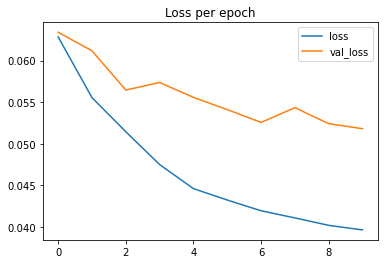

In [74]:
%matplotlib inline
plt.plot(history_model_unet_v2_6_1['loss'],label='loss')
plt.plot(history_model_unet_v2_6_1['val_loss'],label='val_loss')
plt.title('Loss per epoch')
plt.legend();

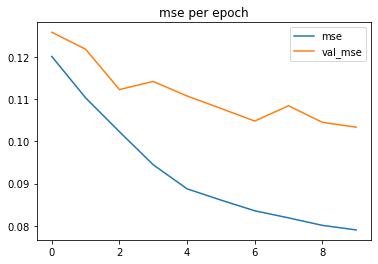

In [75]:
plt.plot(history_model_unet_v2_6_1['mse'],label='mse')
plt.plot(history_model_unet_v2_6_1['val_mse'],label='val_mse')
plt.title('mse per epoch')
plt.legend();

In [ ]:
%matplotlib inline
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

In [80]:
Y_pred=model.predict(X_test)

In [35]:
X_test.shape

(38, 513, 513, 3, 1)

<Figure size 432x288 with 0 Axes>

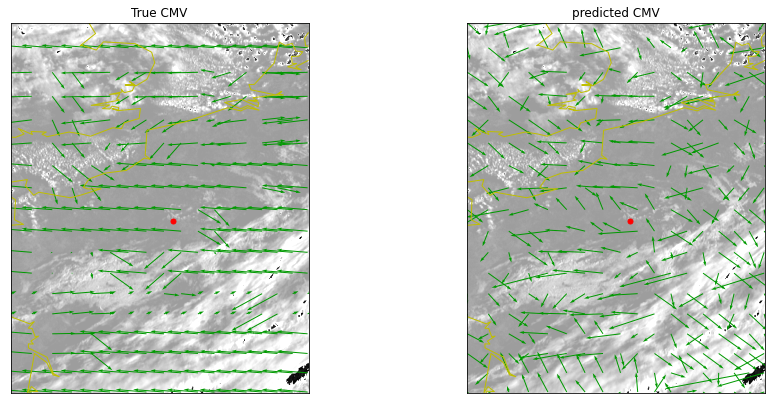

In [87]:
%matplotlib inline
plot_prediction(1,'test',model,X_test,Y_test,cmv_test,35)

In [88]:
dirout='/net/nfs/ssd2/dbennour/Unet_predictions/2020_10_10/'

if not os.path.exists(dirout):
    os.makedirs(dirout)
    print("Directory " , dirout ,  " Created ")
else:    
    print("Directory " , dirout ,  " already exists") 
cmv_x=cmv_test[:,:,:,0]
cmv_y=cmv_test[:,:,:,1]
predictions_to_nc_files(X_test,model,dirout,file_name_list=test_seq,cmv_x=cmv_x,cmv_y=cmv_y)      

Directory  /net/nfs/ssd2/dbennour/Unet_predictions/2020_10_10/  already exists


In [4]:
true_t60=xr.open_dataset('/net/nfs/ssd2/dbennour/CAL_CMV_slot/test_data/CAL_CMV_20201010_1500_1530.nc')
true=xr.open_dataset("/homedata/dbennour/DeepPV/cloud_albedo_forecast/raw_forecast/2020_10_10/raw_cloudindex_202010101500_to_t0.nc")
ex1=xr.open_dataset("/homedata/dbennour/DeepPV/cloud_albedo_forecast/raw_forecast/2020_10_10/raw_cloudindex_202010101500_to_t30.nc")
ex2=xr.open_dataset("/homedata/dbennour/DeepPV/cloud_albedo_forecast/Unet_forecast/2020_10_10/raw_cloudindex_202010101500_to_t30.nc")
cmv1=xr.open_dataset("/homedata/dbennour/DeepPV/cloud_albedo_forecast/Real_CMV/2020_10_10/CMV_BM_MAXCORRcst_20201010_1445_1500.nc")
cmv2=xr.open_dataset("/homedata/dbennour/DeepPV/cloud_albedo_forecast/Unet_cmv/2020_10_10/CMV_BM_MAXCORRcst_20201010_1445_1500.nc")

<Figure size 432x288 with 0 Axes>

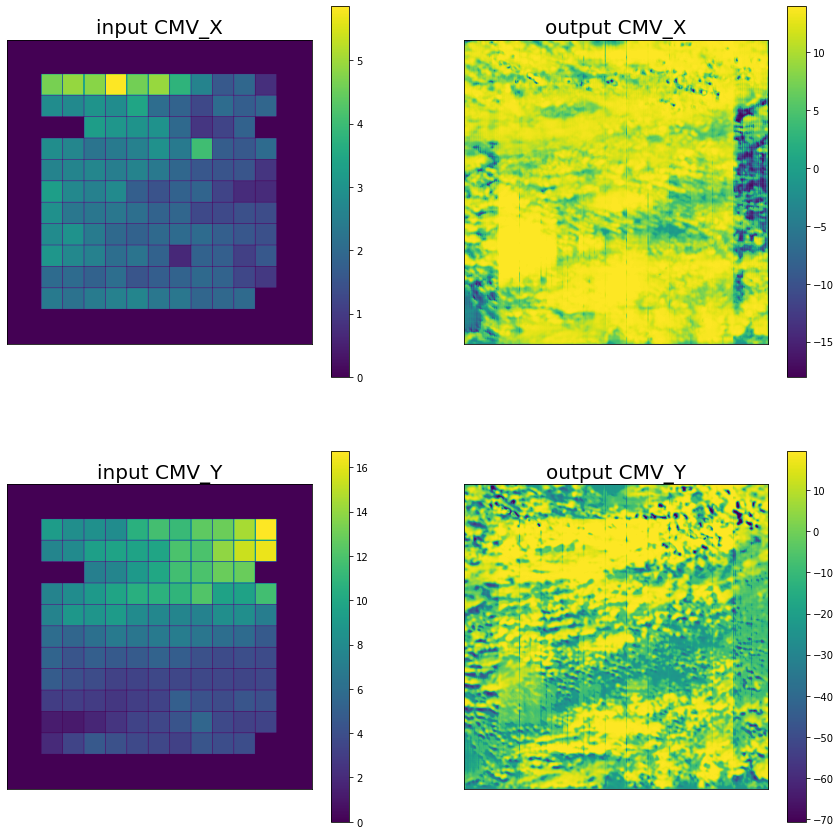

In [5]:
%matplotlib inline
plt.tight_layout()
# plt.figure(figsize=(12,12))
fig=plt.figure(figsize=(15,15));



ax1=fig.add_subplot(2,2,1);
im=plt.imshow(cmv1['CMV_X']);
# plt.colorbar(im);
plt.title('input CMV_X',size=20);
plt.tick_params(
axis='both',          # changes apply to the x-axis
which='both',      # both major and minor ticks are affected
bottom=False,      # ticks along the bottom edge are off
top=False,         # ticks along the top edge are off
left=False,
labelbottom=False,
labelleft=False)
plt.colorbar(im)

plt.subplot(223)
im=plt.imshow(cmv1['CMV_Y']);
# plt.colorbar(im);
plt.title('input CMV_Y',size=20);
plt.tick_params(
axis='both',          # changes apply to the x-axis
which='both',      # both major and minor ticks are affected
bottom=False,      # ticks along the bottom edge are off
top=False,         # ticks along the top edge are off
left=False,
labelbottom=False,
labelleft=False)

plt.colorbar(im)

plt.subplot(222)
im=plt.imshow(cmv2['CMV_X']);
# plt.colorbar(im);
plt.title('output CMV_X',size=20);
plt.tick_params(
axis='both',          # changes apply to the x-axis
which='both',      # both major and minor ticks are affected
bottom=False,      # ticks along the bottom edge are off
top=False,         # ticks along the top edge are off
left=False,
labelbottom=False,
labelleft=False)
plt.colorbar(im)

plt.subplot(224);
im=plt.imshow(cmv2['CMV_Y']);
# plt.colorbar(im);
plt.title('output CMV_Y',size=20);
plt.tick_params(
axis='both',          # changes apply to the x-axis
which='both',      # both major and minor ticks are affected
bottom=False,      # ticks along the bottom edge are off
top=False,         # ticks along the top edge are off
left=False,
labelbottom=False,
labelleft=False)
plt.colorbar(im)
# plt.savefig('202010101500.png')

<Figure size 432x288 with 0 Axes>

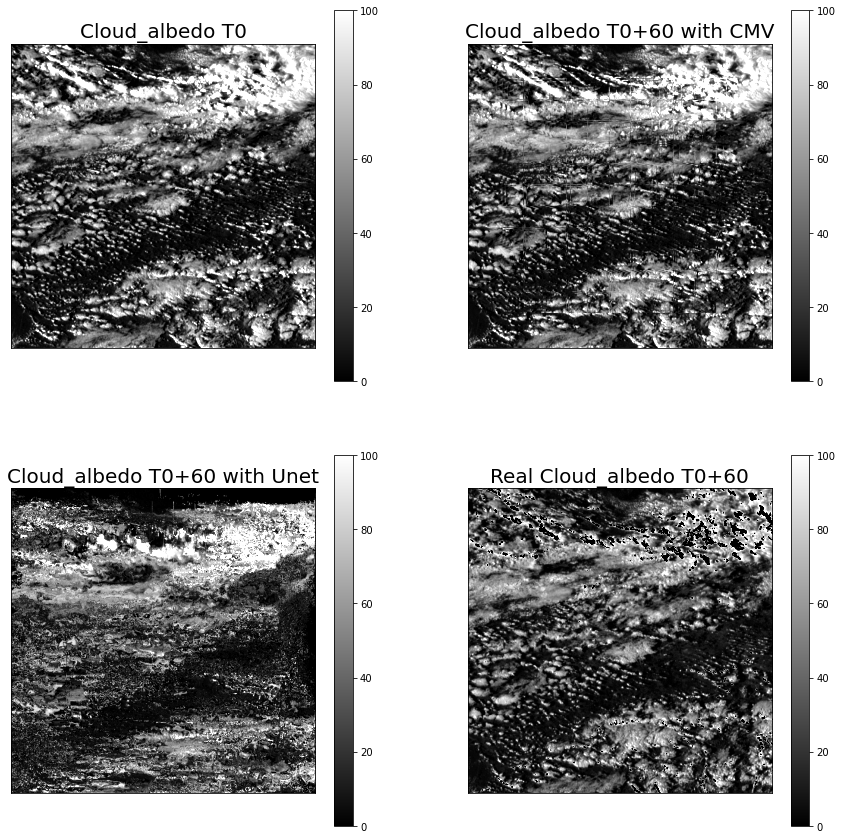

In [7]:
%matplotlib inline
plt.tight_layout()
# plt.figure(figsize=(12,12))
fig=plt.figure(figsize=(15,15));



ax1=fig.add_subplot(2,2,1);
im=plt.imshow(true['Cloud_Albedo']*100,cmap='gray',vmin=0,vmax=100);
# plt.colorbar(im);
plt.title('Cloud_albedo T0',size=20);
plt.tick_params(
axis='both',          # changes apply to the x-axis
which='both',      # both major and minor ticks are affected
bottom=False,      # ticks along the bottom edge are off
top=False,         # ticks along the top edge are off
left=False,
labelbottom=False,
labelleft=False)
plt.colorbar(im)

plt.subplot(222)
im=plt.imshow(ex1['Cloud_Albedo']*100,cmap='gray',vmin=0,vmax=100);
# plt.colorbar(im);
plt.title('Cloud_albedo T0+60 with CMV',size=20);
plt.tick_params(
axis='both',          # changes apply to the x-axis
which='both',      # both major and minor ticks are affected
bottom=False,      # ticks along the bottom edge are off
top=False,         # ticks along the top edge are off
left=False,
labelbottom=False,
labelleft=False)
plt.colorbar(im)

plt.subplot(223)
im=plt.imshow(ex2['Cloud_Albedo']*100,cmap='gray',vmin=0,vmax=100);
# plt.colorbar(im);
plt.title('Cloud_albedo T0+60 with Unet',size=20);
plt.tick_params(
axis='both',          # changes apply to the x-axis
which='both',      # both major and minor ticks are affected
bottom=False,      # ticks along the bottom edge are off
top=False,         # ticks along the top edge are off
left=False,
labelbottom=False,
labelleft=False)
plt.colorbar(im)

plt.subplot(224);
im=plt.imshow(true_t60['CAL_T0'],cmap='gray',vmin=0,vmax=100);
plt.title('Real Cloud_albedo T0+60',size=20);
plt.tick_params(
axis='both',          # changes apply to the x-axis
which='both',      # both major and minor ticks are affected
bottom=False,      # ticks along the bottom edge are off
top=False,         # ticks along the top edge are off
left=False,
labelbottom=False,
labelleft=False)
plt.colorbar(im)
# plt.savefig('202010101500.png')

In [48]:
t60_unet=xr.open_dataset("/mnt/climfs-2.5/lov/pegase/CMV/SirtaDB/cloud_forecast/2020_07_02/raw_cloudindex_202007021400_to_t60.nc")

In [66]:
diff1=ex1['Cloud_Albedo'].values*100-true_t60['CAL_T0'].values
diff2=ex2['Cloud_Albedo'].values*100-true_t60['CAL_T0'].values
diff3=ex2['Cloud_Albedo'].values*100-true['Cloud_Albedo'].values*100
diff4=ex1['Cloud_Albedo'].values*100-true['Cloud_Albedo'].values*100

<Figure size 432x288 with 0 Axes>

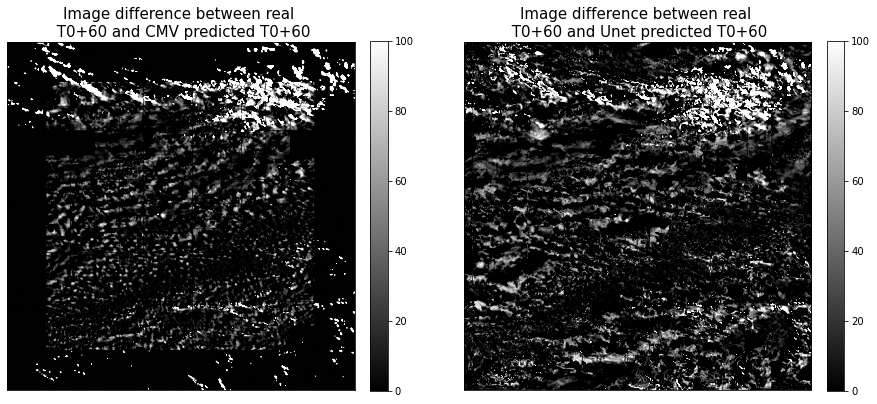

In [67]:
plt.tight_layout()
plt.figure(figsize=(15,15))
plt.subplot(121)
im1=plt.imshow(diff1, cmap='gray',vmin=0,vmax=100)
plt.colorbar(im1,fraction=0.046, pad=0.04)
plt.title('Image difference between real \n T0+60 and CMV predicted T0+60',size=15);
plt.tick_params(
axis='both',          # changes apply to the x-axis
which='both',      # both major and minor ticks are affected
bottom=False,      # ticks along the bottom edge are off
top=False,         # ticks along the top edge are off
left=False,
labelbottom=False,
labelleft=False)
plt.subplot(122)
im2=plt.imshow(diff2, cmap='gray',vmin=0,vmax=100)
plt.colorbar(im2,fraction=0.046, pad=0.04)
plt.title('Image difference between real \n T0+60 and Unet predicted T0+60',size=15);
plt.tick_params(
axis='both',          # changes apply to the x-axis
which='both',      # both major and minor ticks are affected
bottom=False,      # ticks along the bottom edge are off
top=False,         # ticks along the top edge are off
left=False,
labelbottom=False,
labelleft=False)

<Figure size 432x288 with 0 Axes>

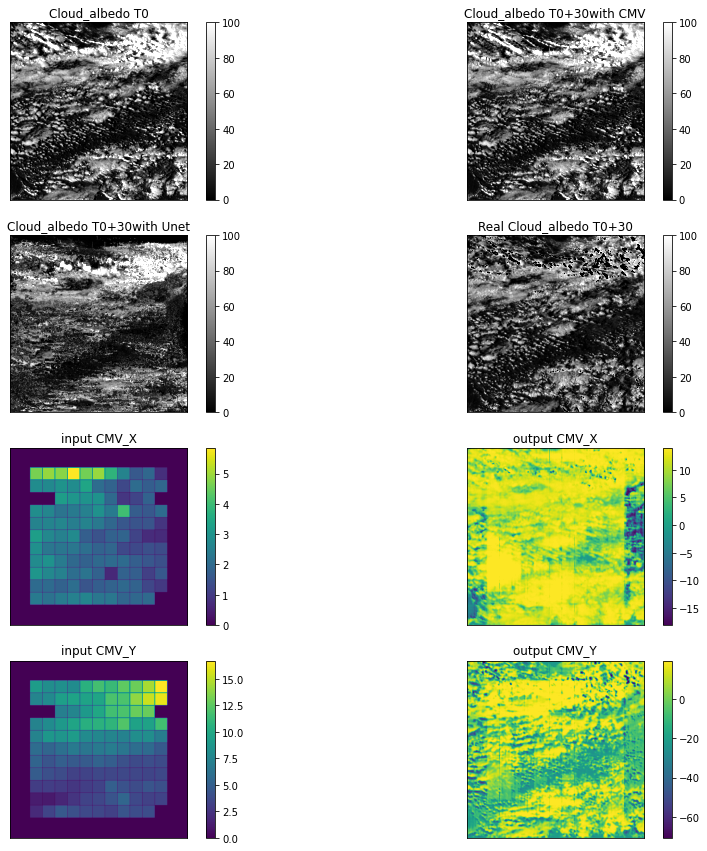

In [7]:
%matplotlib inline
plot_Results('2020_10_10','202010101500','30')